# Grad-CAM - XAI Technique

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

In [ ]:
model = keras.models.Sequential(
        [
          
            keras.layers.InputLayer(input_shape=(224,224, 3)),
            keras.layers.Conv2D(32, kernel_size =(5,5), strides = (2,2),padding = 'same', activation= 'relu'),
            keras.layers.MaxPooling2D(pool_size =(2,2)),
                    
       
            keras.layers.Conv2D(64, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'relu'),
            keras.layers.MaxPooling2D(pool_size =(2,2)),
            
         
            keras.layers.Conv2D(128, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'relu'),
            keras.layers.MaxPooling2D(pool_size =(2,2)),
  
            keras.layers.Flatten(),
            keras.layers.Dropout(0.4),
            
         
            keras.layers.Dense(128, activation = 'relu'),   
            keras.layers.Dropout(0.4), 
           
            keras.layers.Dense(1, activation = 'sigmoid'),
               
        ])   

#Adam Compiler/ Compilador Adam - learning_rate= 0.001
model.compile(optimizer = 'adam' , loss = "binary_crossentropy", metrics = ["accuracy"])
#model.summary()

In [ ]:
model.load_weights('/content/gdrive/MyDrive/Bracis/bracisNB/modelBr35HDataAug.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

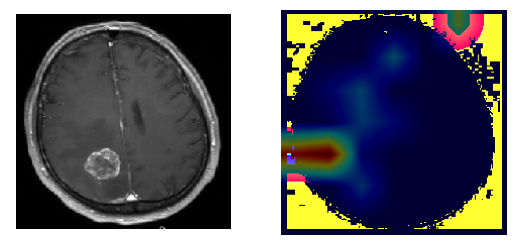

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class
    # Then, we sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # We normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

# Load the image and preprocess it
img_path = '/content/gdrive/MyDrive/Bracis/bracisNB/BMOriginal.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_2') #3rd Conv. Layer

# Resize the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

# Apply colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Overlay the heatmap onto the original image
superimposed_img = (heatmap * 0.4 + img_array[0]).astype(np.uint8)
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)


# Save the heatmap image
cv2.imwrite('/content/gdrive/MyDrive/Bracis/bracisNB/BMHeatMap.png', heatmap)

# Show the original image and the heatmap side-by-side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(superimposed_img)
ax[1].axis('off')
plt.show()


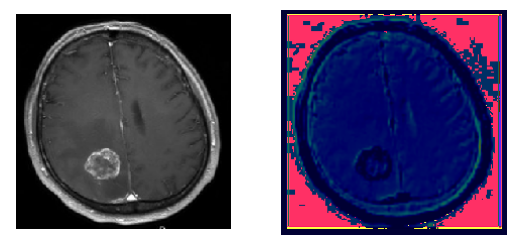

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Load the image and preprocess it
img_path = '/content/gdrive/MyDrive/Bracis/bracisNB/BMOriginal.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d')

# Resize the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

# Apply colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Overlay the heatmap onto the original image
superimposed_img = (heatmap * 0.4 + img_array[0]).astype(np.uint8)
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)

# Save the heatmap image
cv2.imwrite('/content/gdrive/MyDrive/Bracis/bracisNB/BMHeatMapConv1.png', heatmap)

# Show the original image and the heatmap side-by-side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(superimposed_img)
ax[1].axis('off')
plt.show()


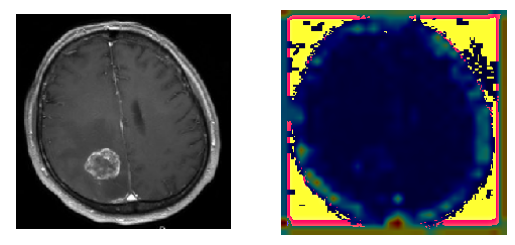

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Load the image and preprocess it
img_path = '/content/gdrive/MyDrive/Bracis/bracisNB/BMOriginal.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_1')

# Resize the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

# Apply colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Overlay the heatmap onto the original image
superimposed_img = (heatmap * 0.4 + img_array[0]).astype(np.uint8)
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)

# Save the heatmap image
cv2.imwrite('/content/gdrive/MyDrive/Bracis/bracisNB/BMHeatMapConv2.png', heatmap)

# Show the original image and the heatmap side-by-side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(superimposed_img)
ax[1].axis('off')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Load the image and preprocess it
img_path = '/content/gdrive/MyDrive/Bracis/bracisNB/BMOriginal.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_2')

# Resize the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

# Apply colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Overlay the heatmap onto the original image
superimposed_img = (heatmap * 0.4 + img_array[0]).astype(np.uint8)
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)

# Save the heatmap image
cv2.imwrite('/content/gdrive/MyDrive/Bracis/bracisNB/BMHeatMapConv3.png', heatmap)

# Show the original image and the heatmap side-by-side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(superimposed_img)
ax[1].axis('off')
plt.show()